In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
#
from sklearn.model_selection import train_test_split
import os
import shutil
import zipfile

print("Numpy Version:          " , np.__version__)
print("Pandas Version:         " , pd.__version__)
print("Seaborn Version:        " , sns.__version__)
print("PyTorch Version:        " , torch.__version__)

Numpy Version:           1.26.2
Pandas Version:          2.1.3
Seaborn Version:         0.13.0
PyTorch Version:         2.1.2


#### Custom Function(s)

In [2]:
def unzip_dataset():
    """
    unzip a zip & move file/folder
    """
    # initialize variables
    zip_file_path        = '../Data/LIDC Data.zip' # zip path
    extract_to_directory = '../Data'               # extract path
    source_folder        = '../Data/LIDC Data'     # source path
    destination_folder   = '../Data'               # destination path
    
    # check if the zip file exists
    if os.path.exists(zip_file_path) and zipfile.is_zipfile(zip_file_path):
        # create the extraction directory if it doesn't exist
        if not os.path.exists(extract_to_directory):
            os.makedirs(extract_to_directory)
        
        # extract the contents of the zip file
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_directory)
        
        print(f"Files extracted to '{extract_to_directory}'.")
    else:
        print(f"The specified file '{zip_file_path}' is either not found or not a valid zip file.")

    # get all contents (files and subdirectories) of the source folder
    contents = os.listdir(source_folder)

    # # move each item from the source folder to the destination folder
    for item in contents:
        item_path = os.path.join(source_folder, item)
        destination_path = os.path.join(destination_folder, item)

        # move the item to the destination folder
        try:
            shutil.move(item_path, destination_path)
            print(f"Moved '{item_path}' to '{destination_path}'")
        except shutil.Error as e:
            print(f"Error: {e} - '{item_path}' could not be moved.")

    # delete the original source folder after moving its contents
    try:
        shutil.rmtree(source_folder)
        print(f"Original folder '{source_folder}' deleted.")
    except shutil.Error as e:
        print(f"Error: {e} - '{source_folder}' could not be deleted.")

    return

In [3]:
def test_train_image(df):
    """
    Move Original images into the train/test folder & return
    DataFrame with the file path and label.
    """
    # initialize variable
    seed            = 1776
    train_directory = '../Data/train/'
    test_directory  = '../Data/test/'
    data_directory  = '../Data/LIDC(MaxSlices)_Nodules/'
    test_size       = 0.2

    # keep only two columns
    columns_to_keep = ['noduleID', 'Malignancy']
    df_filtered = df[columns_to_keep].copy()

    # new column
    df_filtered['file_name'] = df_filtered.noduleID.astype(str) + '.txt'
    df_filtered.drop('noduleID', axis=1, inplace=True)

    # list of files 
    dir_list = os.listdir(data_directory)

    # compare labeled files to data directory
    difference_list1_list2 = list(set(dir_list) - set(df_filtered.file_name.tolist()))
    difference_list2_list1 = list(set(df_filtered.file_name.tolist()) - set(dir_list))
    
    # print("Elements in dir_list but not in DF:", difference_list1_list2)
    # print("Elements in DF but not in dir_list:", difference_list2_list1)

    # filtering rows where 'file_name' is not in values_to_remove
    df_filtered = df_filtered[~df_filtered['file_name'].isin(difference_list2_list1)]
    
    # use to split train and test
    X = df_filtered.file_name.tolist()
    y = df_filtered.Malignancy.tolist()
    
    # train is image & test is malignancy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify = y)
    
    # create train directory if it doesn't exist
    if not os.path.exists(train_directory):
        os.makedirs(train_directory)
        
    # create test directory if it doesn't exist
    if not os.path.exists(test_directory):
        os.makedirs(test_directory)
    
    # move train file from the array to the train directory
    for file_name in X_train:
        # full path of the file to be moved
        file_path = os.path.join(data_directory, file_name)
    
        # check if the file exists before moving
        if os.path.exists(file_path):
            shutil.move(file_path, os.path.join(train_directory, file_name))
            # print(f"Moved {file_name} to {train_directory}")
        else:
            print(f"File {file_name} not found in {data_directory}")
    
    # move each file from the array to the test directory
    for file_name in X_test:
        # full path of the file to be moved
        file_path = os.path.join(data_directory, file_name)
    
        # check if the file exists before moving it
        if os.path.exists(file_path):
            shutil.move(file_path, os.path.join(test_directory, file_name))
            # print(f"Moved {file_name} to {test_directory}")
        else:
            print(f"File {file_name} not found in {data_directory}")
    
    # delete data folder after the move
    if os.path.exists(data_directory) and os.path.isdir(data_directory):
        try:
            os.rmdir(data_directory)
            print(f"Folder '{data_directory}' has been successfully deleted.")
        except OSError as e:
            print(f"Error: {e} - Folder '{data_directory}' could not be deleted.")
    else:
        print(f"Folder '{data_directory}' does not exist.")


    # append to each element in the array (train & test)
    X_train = [train_directory + file for file in X_train]
    X_test  = [test_directory + file for file in X_test]
    
    # create a DataFrame by combining the arrays
    data1 = {'file_path': X_train, 'label': y_train}
    df_train   = pd.DataFrame(data1)
    #
    data2 = {'file_path': X_test, 'label': y_test}
    df_test  = pd.DataFrame(data2)

    # print
    print('\n')
    print(df_filtered.Malignancy.value_counts())

    return df_train, df_test

#### Prep Images for PyTorch

In [4]:
# unzip
unzip_dataset()
# read csv
df = pd.read_csv("../Data/LIDC_newMode_2022.csv")
# process images
df_train, df_test = test_train_image(df)

Files extracted to '../Data'.
Moved '../Data/LIDC Data/LIDC_newMode_2022.csv' to '../Data/LIDC_newMode_2022.csv'
Moved '../Data/LIDC Data/LIDC(MaxSlices)_Nodules' to '../Data/LIDC(MaxSlices)_Nodules'
Original folder '../Data/LIDC Data' deleted.
Folder '../Data/LIDC(MaxSlices)_Nodules/' has been successfully deleted.


Malignancy
3    1192
2     562
4     356
1     335
5     235
Name: count, dtype: int64


In [5]:
len(df_train)

2144

In [6]:
# display random from DataFrame train
df_train.sample(n=5)

,file_path,label
1090,../Data/train/1015.txt,4
1537,../Data/train/119.txt,2
1877,../Data/train/1435.txt,3
591,../Data/train/2413.txt,3
549,../Data/train/1793.txt,3


In [7]:
# display random from DataFrame train
df_test.sample(n=5)

,file_path,label
141,../Data/test/1039.txt,4
198,../Data/test/224.txt,4
362,../Data/test/2436.txt,3
128,../Data/test/324.txt,5
528,../Data/test/464.txt,2


### Load Images to DataLoader

In [8]:
# # import images to DataLoader
# # initialize variables
# batch_size = 128
# train_data = []
# test_data = []

# # training
# for i in range(len(df_train)):
#    train_data.append([(np.loadtxt(df_train.file_path[i])).astype(np.float32), df_train.label[i]])

# # testing
# for i in range(len(df_test)):
#    test_data.append([(np.loadtxt(df_test.file_path[i])).astype(np.float32), df_test.label[i]])

# # train dataloader
# trainloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, pin_memory=True, num_workers=4)
# i1, l1 = next(iter(trainloader))
# print("Training", i1.shape)

# # test dataloader
# testloader = DataLoader(test_data, shuffle=True, batch_size=batch_size, pin_memory=True, num_workers=4)
# i1, l1 = next(iter(testloader))
# print("Testing", i1.shape)

In [9]:
# # use GPU
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# # iterate over the DataLoader as usual, and the data will be automatically moved to the GPU
# for batch in trainloader:
#     train_input_data, train_target = batch
#     train_input_data, train_target = train_input_data.to(device), train_target.to(device)

# for batch in testloader:
#     test_input_data, test_target = batch
#     test_input_data, test_target = test_input_data.to(device), test_target.to(device)


# print("Training", train_input_data.shape, train_target.shape)
# print("Testing", test_input_data.shape, test_target.shape)

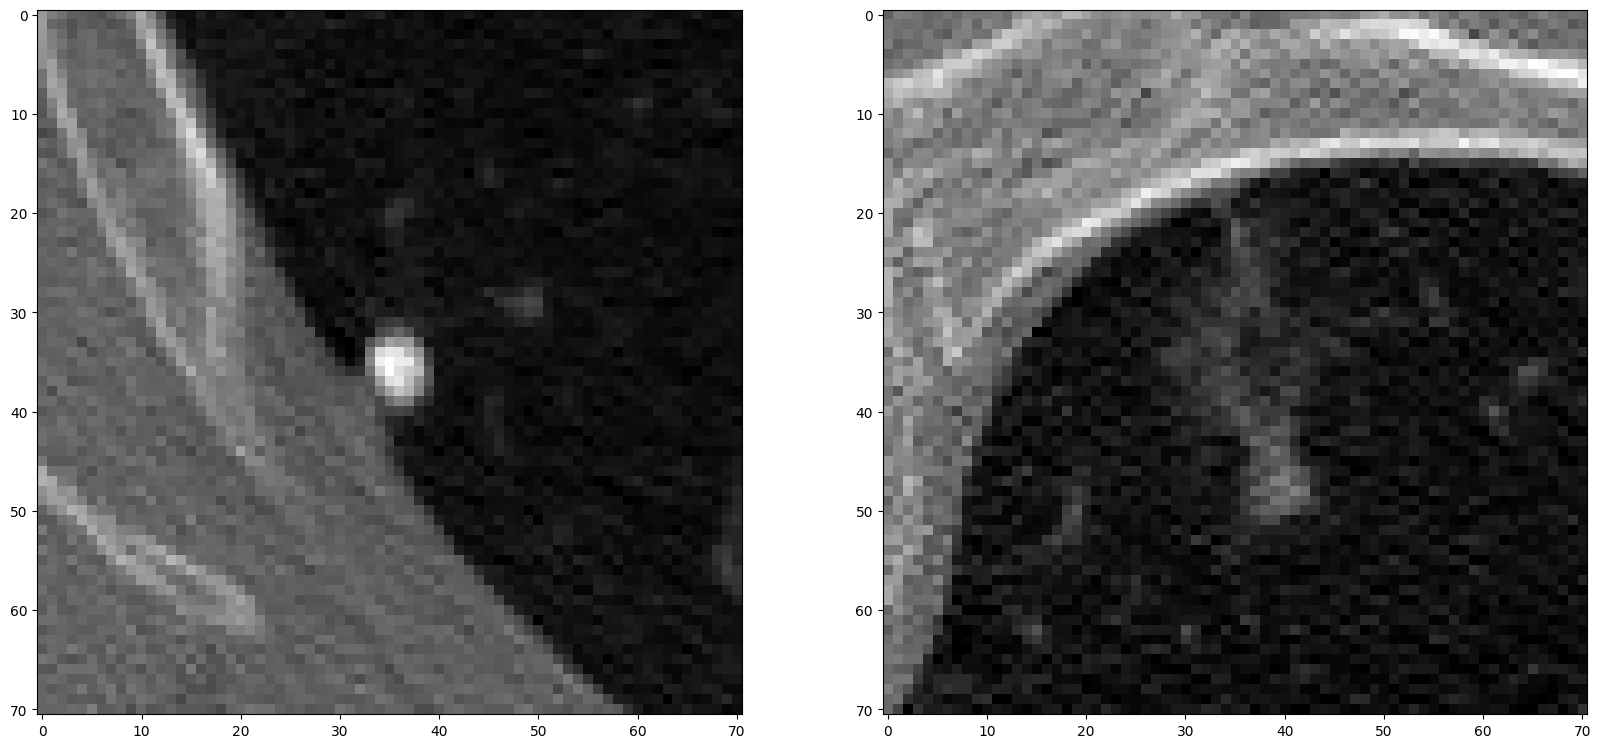

In [10]:
fig, axs = plt.subplots(1,2, figsize=(20,10))

pic_array0 = np.loadtxt(df_train.file_path[0])
axs[0].imshow(pic_array0, cmap="gray")
pic_array1 = np.loadtxt(df_train.file_path[1])
axs[1].imshow(pic_array1, cmap="gray")

plt.show()

## Define Convolutional Autoencoders

In [11]:
# Custom Autoencoder Model
class ConvAutoencoder1(nn.Module):
    def __init__(self):
        super(ConvAutoencoder1, self).__init__()
        self.encoder = nn.Sequential(
            # 1 channel # 16 different filters & 3x3 kernel & kernel moves three pixel &  one-pixel border of zero-padding
            # nn.Conv2d(1, 16, kernel_size=3, stride=3, padding=1),
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
# define a convolutional autoencoder class
class ConvAutoencoder2(nn.Module):
    def __init__(self):
        super(ConvAutoencoder2, self).__init__()

        # encoder layers
        self.encoder = nn.Sequential(
            # 1 channel # 16 different filters & 3x3 kernel & kernel moves two pixel &  one-pixel border of zero-padding
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        # decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # use sigmoid to ensure output is in the range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [13]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # first column contains file paths
        label = self.dataframe.iloc[idx, 1]     # second column contains labels
        data =  np.loadtxt(img_path)            # load txt file into numpy array
        
        # convert numpy array to PIL Image and convert to grayscale if needed
        img = Image.fromarray(data.astype(np.float32)).convert('L')

        if self.transform:
            img = self.transform(img)

        return img, label

In [14]:
# define the transformation to be applied to each image
transform = transforms.Compose([
    transforms.Resize((72, 72)),  # Resize the image to 72x72
    transforms.ToTensor(),        # Convert the image to a PyTorch tensor
])

# create an instance of Custom Dataset
custom_train = CustomDataset(dataframe=df_train, transform=transform)
custom_test = CustomDataset(dataframe=df_test, transform=transform)

# create a DataLoader to efficiently load and iterate through the dataset
batch_size = 128

train_loader = DataLoader(dataset=custom_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=custom_test, batch_size=batch_size, shuffle=True)

In [15]:
type(train_loader), type(test_loader)

(torch.utils.data.dataloader.DataLoader,
 torch.utils.data.dataloader.DataLoader)

## ConvAutoencoder1

In [16]:
# set random seed for reproducibility
torch.manual_seed(1776)

# initialize the model, loss function, and optimizer
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
autoencoder1 = ConvAutoencoder1().to(device)
# 
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder1.parameters(), lr=0.001)

# training loop
num_epochs = 30
print_interval = 3  # print the loss every other epoch

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = autoencoder1(img)
        loss = criterion(outputs, img)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # print the loss every other epoch
    if epoch % print_interval == 0 or epoch == num_epochs - 1:
        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# Save the entire model (including architecture and trained weights)
model_path = './Model/autoencoder1_model.pth'
torch.save(autoencoder1, model_path)

# Load the entire model
# autoencoder1 = torch.load(model_path)

Training - Epoch [1/30], Loss: 0.2219
Training - Epoch [4/30], Loss: 0.0264
Training - Epoch [7/30], Loss: 0.0141
Training - Epoch [10/30], Loss: 0.0082
Training - Epoch [13/30], Loss: 0.0054
Training - Epoch [16/30], Loss: 0.0032
Training - Epoch [19/30], Loss: 0.0021
Training - Epoch [22/30], Loss: 0.0017
Training - Epoch [25/30], Loss: 0.0014
Training - Epoch [28/30], Loss: 0.0011
Training - Epoch [30/30], Loss: 0.0010


In [17]:
len(test_loader.dataset)

536

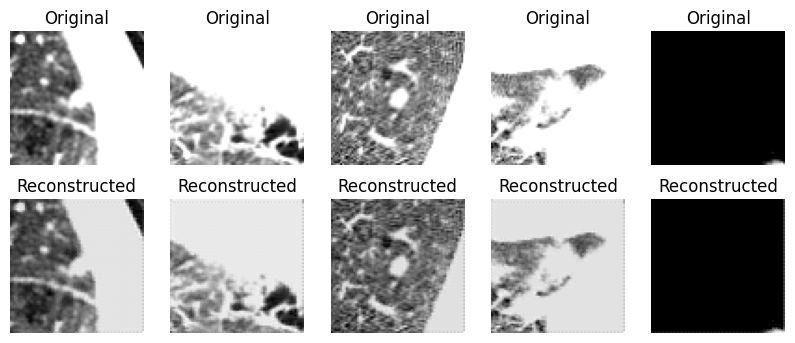

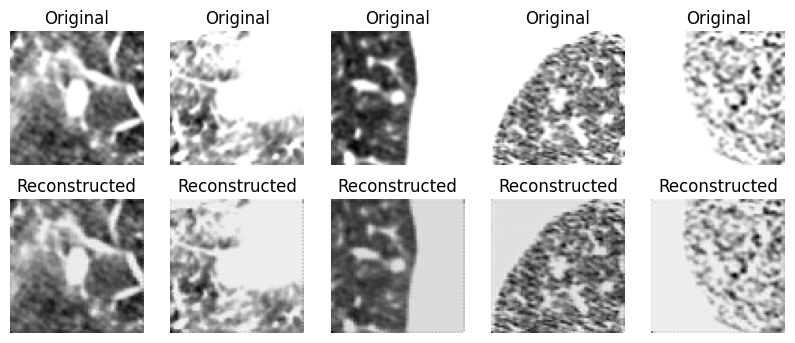

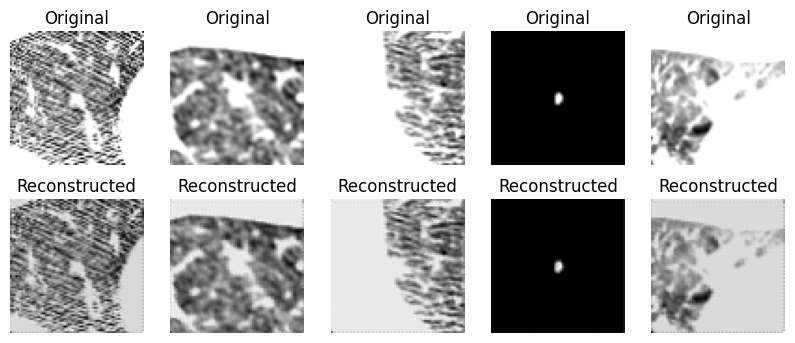

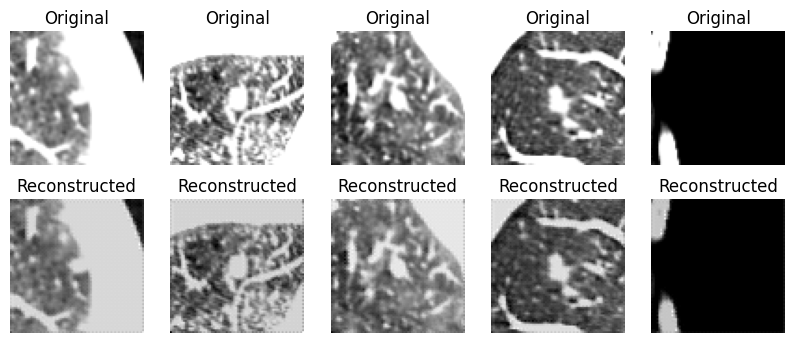

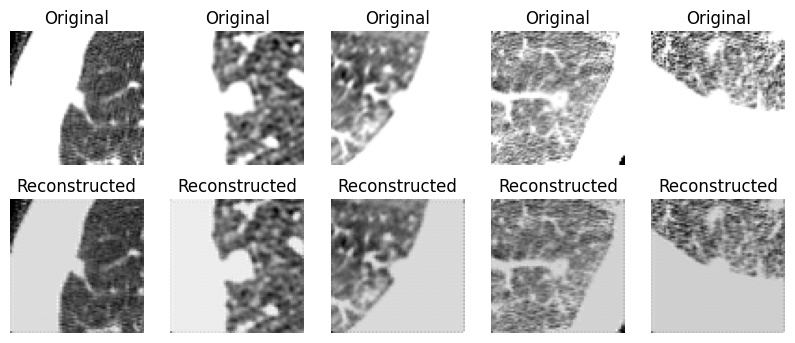

Testing - Average Loss: 0.0000


In [18]:
# Testing loop
autoencoder1.eval()  # Set the model to evaluation mode


# Testing loop
test_loss = 0
with torch.no_grad():
    for data in test_loader:
        test_images, _ = data
        # GPU
        test_images    = test_images.to(device)

        # Print data types before casting
        # print("Test images data type:", test_images.dtype)
        # print("Model weights data type:", autoencoder1.parameters().__next__().dtype)
        
        test_outputs = autoencoder1(test_images)
        test_loss += criterion(test_outputs, test_images).item()

        # move the images back to CPU
        test_images  = test_images.to('cpu')
        test_outputs = test_outputs.to('cpu')
                                       
        # plot original and reconstructed images
        plt.figure(figsize=(10, 4))
    
        for i in range(5):
            # original image
            plt.subplot(2, 5, i + 1)
            plt.imshow(test_images[i][0], cmap='gray')
            plt.title('Original')
            plt.axis('off')
    
            # reconstructed image
            plt.subplot(2, 5, i + 6)
            plt.imshow(test_outputs[i][0], cmap='gray')
            plt.title('Reconstructed')
            plt.axis('off')
    
        plt.show()

# Calculate the average test loss
average_test_loss = test_loss / len(test_loader.dataset)
print(f'Testing - Average Loss: {average_test_loss:.4f}')

## ConvAutoencoder2

In [19]:
# set random seed for reproducibility
torch.manual_seed(1776)

# initialize the model, loss function, and optimizer
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
autoencoder2 = ConvAutoencoder2().to(device)
# 
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder2.parameters(), lr=0.001)

# training loop
num_epochs = 30
print_interval = 3

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        
        # forward pass
        output = autoencoder2(img)
        loss = criterion(output, img)

        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print the loss every other epoch
    if epoch % print_interval == 0 or epoch == num_epochs - 1:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the entire model (including architecture and trained weights)
model_path = './Model/autoencoder2_model.pth'
torch.save(autoencoder2, model_path)

# Load the entire model
# autoencoder1 = torch.load(model_path)

Epoch [1/30], Loss: 0.1036
Epoch [4/30], Loss: 0.0319
Epoch [7/30], Loss: 0.0143
Epoch [10/30], Loss: 0.0108
Epoch [13/30], Loss: 0.0099
Epoch [16/30], Loss: 0.0072
Epoch [19/30], Loss: 0.0075
Epoch [22/30], Loss: 0.0067
Epoch [25/30], Loss: 0.0051
Epoch [28/30], Loss: 0.0052
Epoch [30/30], Loss: 0.0060


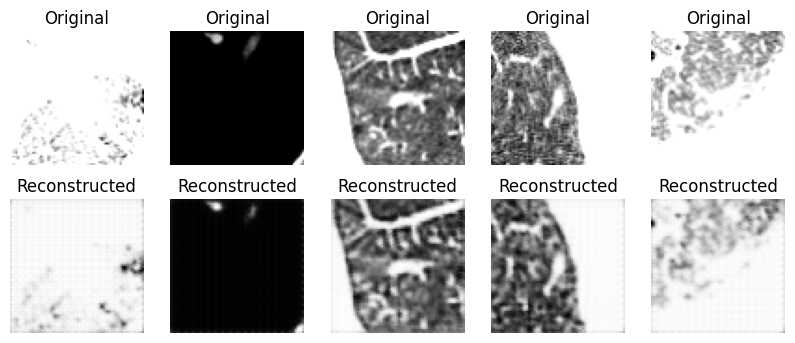

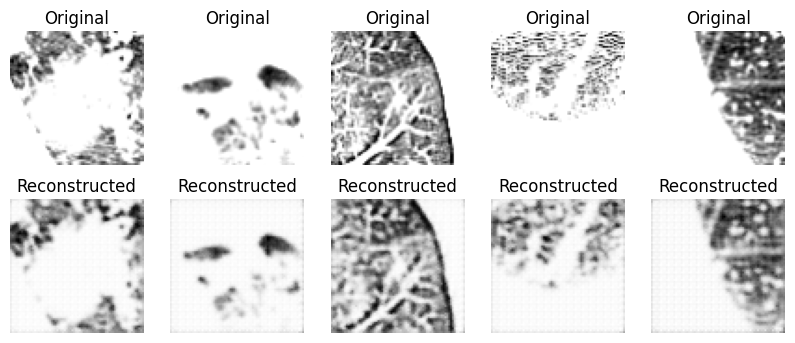

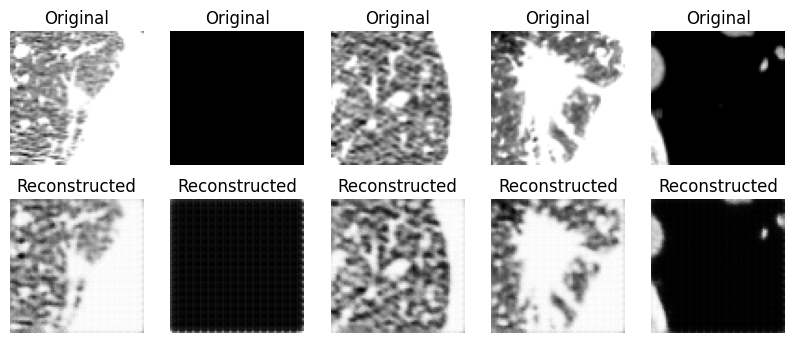

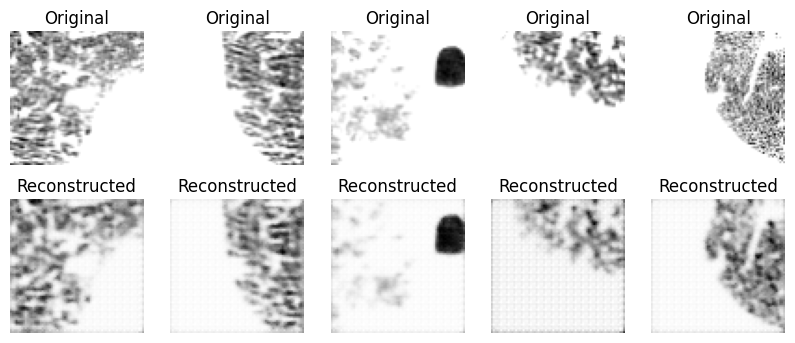

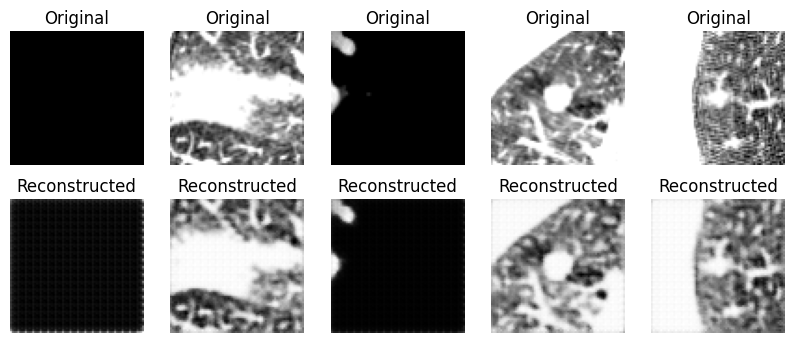

Testing - Average Loss: 0.0000


In [20]:
# Testing loop
autoencoder2.eval()  # Set the model to evaluation mode


# Testing loop
test_loss = 0
with torch.no_grad():
    for data in test_loader:
        test_images, _ = data
        # GPU
        test_images    = test_images.to(device)

        # Print data types before casting
        # print("Test images data type:", test_images.dtype)
        # print("Model weights data type:", autoencoder1.parameters().__next__().dtype)
        
        test_outputs = autoencoder2(test_images)
        test_loss += criterion(test_outputs, test_images).item()

        # move the images back to CPU
        test_images  = test_images.to('cpu')
        test_outputs = test_outputs.to('cpu')
                                       
        # plot original and reconstructed images
        plt.figure(figsize=(10, 4))
    
        for i in range(5):
            # original image
            plt.subplot(2, 5, i + 1)
            plt.imshow(test_images[i][0], cmap='gray')
            plt.title('Original')
            plt.axis('off')
    
            # reconstructed image
            plt.subplot(2, 5, i + 6)
            plt.imshow(test_outputs[i][0], cmap='gray')
            plt.title('Reconstructed')
            plt.axis('off')
    
        plt.show()

# Calculate the average test loss
average_test_loss = test_loss / len(test_loader.dataset)
print(f'Testing - Average Loss: {average_test_loss:.4f}')

### Extract Flatten Layer

In [24]:
# Custom Autoencoder Model
class ConvAutoencoder3(nn.Module):
    def __init__(self):
        super(ConvAutoencoder3, self).__init__()
        self.encoder = nn.Sequential(
            # 1 channel # 16 different filters & 3x3 kernel & kernel moves three pixel &  one-pixel border of zero-padding
            # nn.Conv2d(1, 16, kernel_size=3, stride=3, padding=1),
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def get_flattened_output(self, x):
        # This method returns the flattened output without performing a forward pass
        # It can be used to extract the flattened representation without affecting the model's state
        # Make sure to call model.eval() before using this method to ensure the model is in evaluation mode
        # ... (your model layers up to the flatten layer)
        return flattened_output

In [26]:
# set random seed for reproducibility
torch.manual_seed(1776)

# initialize the model, loss function, and optimizer
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
autoencoder3 = ConvAutoencoder3().to(device)
# 
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder3.parameters(), lr=0.001)

# training loop
num_epochs = 10
print_interval = 3  # print the loss every other epoch

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = autoencoder3(img)
        loss = criterion(outputs, img)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # print the loss every other epoch
    if epoch % print_interval == 0 or epoch == num_epochs - 1:
        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Training - Epoch [1/10], Loss: 0.2219
Training - Epoch [4/10], Loss: 0.0264
Training - Epoch [7/10], Loss: 0.0141
Training - Epoch [10/10], Loss: 0.0082


In [50]:
import torch.nn.functional as F

# Set the model to evaluation mode
autoencoder3.eval()

# load txt file into numpy array
data =  np.loadtxt('../Data/train/1370.txt')            

# convert NumPy array to PyTorch tensor
torch_tensor = torch.tensor(data).to(dtype=torch.float32)

# Resize the tensor to shape (72, 72)
resized_tensor = F.interpolate(torch_tensor.unsqueeze(0).unsqueeze(0), size=(72, 72), mode='bilinear', align_corners=False)
resized_tensor = resized_tensor.squeeze()

#
autoencoder3.forward(resized_tensor) tre5w

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [72, 72]

In [51]:
5000/256

19.53125

In [ ]:
# define a convolutional autoencoder class
class ConvAutoencoderX(nn.Module):
    def __init__(self):
        super(ConvAutoencoderX, self).__init__()

        # encoder layers
        self.encoder = nn.Sequential(
            # 1 channel # 16 different filters & 3x3 kernel & kernel moves two pixel &  one-pixel border of zero-padding
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        # decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # use sigmoid to ensure output is in the range [0, 1]
        )

    def forward(self, x):
        # take a copy of X as y
        # call flatten by passing the y
        # print or save the output
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def flatten(self, x):
        //TODO